In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import plotly.graph_objects as go
from sklearn import preprocessing
import datetime 
import plotly

Data used is from the IEEE Fraud Detection 

TransactionDT: 

timedelta from a given reference datetime (not an actual timestamp)
“TransactionDT first value is 86400, which corresponds to the number of seconds in a day (60 * 60 * 24 = 86400) so I think the unit is seconds. Using this, we know the data spans 6 months, as the maximum value is 15811131, which would correspond to day 183.”

TransactionAMT: 

transaction payment amount in USD
“Some of the transaction amounts have three decimal places to the right of the decimal point. There seems to be a link to three decimal places and a blank addr1 and addr2 field. Is it possible that these are foreign transactions and that, for example, the 75.887 in row 12 is the result of multiplying a foreign currency amount by an exchange rate?”

ProductCD: 

product code, the product for each transaction
“Product isn't necessary to be a real 'product' (like one item to be added to the shopping cart). It could be any kind of service.”

card1 - card6: 

payment card information, such as card type, card category, issue bank, country, etc.

addr: 

address
“both addresses are for purchaser
addr1 as billing region
addr2 as billing country”

dist: 

distance
"distances between (not limited) billing address, mailing address, zip code, IP address, phone area, etc.”

P_ and (R__) emaildomain: 

purchaser and recipient email domain
“ certain transactions don't need recipient, so R_emaildomain is null.”

C1-C14: 

counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
“Can you please give more examples of counts in the variables C1-15? Would these be like counts of phone numbers, email addresses, names associated with the user? I can't think of 15.
Your guess is good, plus like device, ipaddr, billingaddr, etc. Also these are for both purchaser and recipient, which doubles the number.”

D1-D15: 

timedelta, such as days between previous transaction, etc.
M1-M9: 

match, such as names on card and address, etc.
Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.
“For example, how many times the payment card associated with a IP and email or address appeared in 24 hours time range, etc.”
"All Vesta features were derived as numerical. some of them are count of orders within a clustering, a time-period or condition, so the value is finite and has ordering (or ranking). I wouldn't recommend to treat any of them as categorical. If any of them resulted in binary by chance, it maybe worth trying."

Identity Table

Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

“id01 to id11 are numerical features for identity, which is collected by Vesta and security partners such as device rating, ip_domain rating, proxy rating, etc. Also it recorded behavioral fingerprint like account login times/failed to login times, how long an account stayed on the page, etc. All of these are not able to elaborate due to security partner T&C. I hope you could get basic meaning of these features, and by mentioning them as numerical/categorical, you won't deal with them inappropriately.”

Labeling logic

"The logic of our labeling is define reported chargeback on the card as fraud transaction (isFraud=1) and transactions posterior to it with either user account, email address or billing address directly linked to these attributes as fraud too. If none of above is reported and found beyond 120 days, then we define as legit transaction (isFraud=0).
However, in real world fraudulent activity might not be reported, e.g. cardholder was unaware, or forgot to report in time and beyond the claim period, etc. In such cases, supposed fraud might be labeled as legit, but we never could know of them. Thus, we think they're unusual cases and negligible portion." 


In [ ]:
bdef resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def CalcOutliers(df_num): 

    # calculating mean and std of the array
    data_mean, data_std = np.mean(df_num), np.std(df_num)

    # seting the cut line to both higher and lower values
    # You can change this value
    cut = data_std * 3

    #Calculating the higher and lower cut values
    lower, upper = data_mean - cut, data_mean + cut

    # creating an array of lower, higher and total outlier values 
    outliers_lower = [x for x in df_num if x < lower]
    outliers_higher = [x for x in df_num if x > upper]
    outliers_total = [x for x in df_num if x < lower or x > upper]

    # array without outlier values
    outliers_removed = [x for x in df_num if x > lower and x < upper]
    
    print('Identified lowest outliers: %d' % len(outliers_lower)) # printing total number of values in lower cut of outliers
    print('Identified upper outliers: %d' % len(outliers_higher)) # printing total number of values in higher cut of outliers
    print('Total outlier observations: %d' % len(outliers_total)) # printing total number of values outliers of both sides
    print('Non-outlier observations: %d' % len(outliers_removed)) # printing total number of non outlier values
    print("Total percentual of Outliers: ", round((len(outliers_total) / len(outliers_removed) )*100, 4)) # Percentual of outliers in points
    
    return

In [ ]:
df_id = pd.read_csv("/content/drive/MyDrive/HCYHI/IEEE-Fraud-Detection/train_identity.csv")
df_trans = pd.read_csv("/content/drive/MyDrive/HCYHI/IEEE-Fraud-Detection/train_transaction.csv")

In [ ]:
df_trans = reduce_mem_usage(df_trans)
df_id = reduce_mem_usage(df_id)

Mem. usage decreased to 542.35 Mb (69.4% reduction)
Mem. usage decreased to 25.86 Mb (42.7% reduction)


In [ ]:
resumetable(df_trans)[:25]

Dataset Shape: (590540, 394)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,TransactionID,int32,0,590540,2987000,2987001,2987002,19.17
1,isFraud,int8,0,2,0,0,0,0.22
2,TransactionDT,int32,0,573349,86400,86401,86469,19.11
3,TransactionAmt,float16,0,8195,68.5,29,59,8.10
4,ProductCD,object,0,5,W,W,W,1.28
5,card1,int16,0,13553,13926,2755,4663,9.97
6,card2,float16,8933,500,NaN,404,490,6.32
7,card3,float16,1565,114,150,150,150,0.68
8,card4,object,1577,4,discover,mastercard,visa,1.09
9,card5,float16,4259,119,142,102,166,2.66


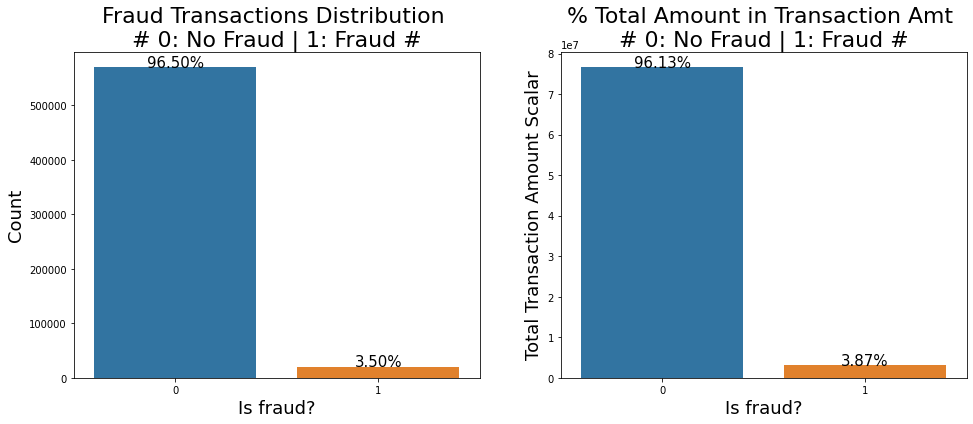

In [ ]:
df_trans['TransactionAmt'] = df_trans['TransactionAmt'].astype(float)
total = len(df_trans)
total_amt = df_trans.groupby(['isFraud'])['TransactionAmt'].sum().sum()
plt.figure(figsize=(16,6))

plt.subplot(121)
g = sns.countplot(x='isFraud', data=df_trans, )
g.set_title("Fraud Transactions Distribution \n# 0: No Fraud | 1: Fraud #", fontsize=22)
g.set_xlabel("Is fraud?", fontsize=18)
g.set_ylabel('Count', fontsize=18)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=15) 

perc_amt = (df_trans.groupby(['isFraud'])['TransactionAmt'].sum())
perc_amt = perc_amt.reset_index()
plt.subplot(122)
g1 = sns.barplot(x='isFraud', y='TransactionAmt',  dodge=True, data=perc_amt)
g1.set_title("% Total Amount in Transaction Amt \n# 0: No Fraud | 1: Fraud #", fontsize=22)
g1.set_xlabel("Is fraud?", fontsize=18)
g1.set_ylabel('Total Transaction Amount Scalar', fontsize=18)
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total_amt * 100),
            ha="center", fontsize=15) 
    
plt.show()

In [ ]:
df_trans['TransactionAmt'] = df_trans['TransactionAmt'].astype(float)
print("Transaction Amounts Quantiles:")
print(df_trans['TransactionAmt'].quantile([.01, .025, .1, .25, .5, .75, .9, .975, .99]))


Transaction Amounts Quantiles:
0.010       9.242188
0.025      14.500000
0.100      25.953125
0.250      43.312500
0.500      68.750000
0.750     125.000000
0.900     275.250000
0.975     648.262500
0.990    1104.000000
Name: TransactionAmt, dtype: float64


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


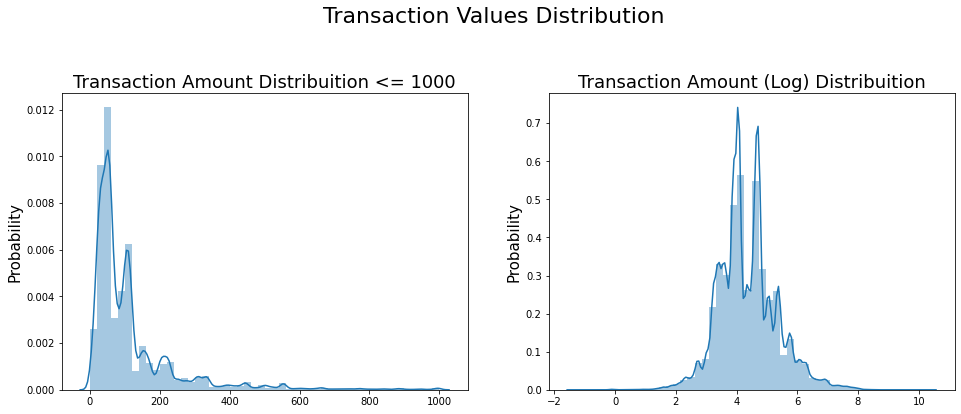

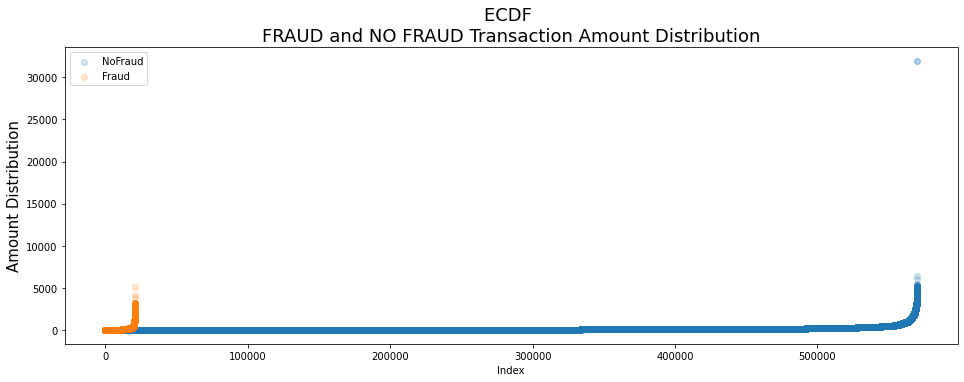

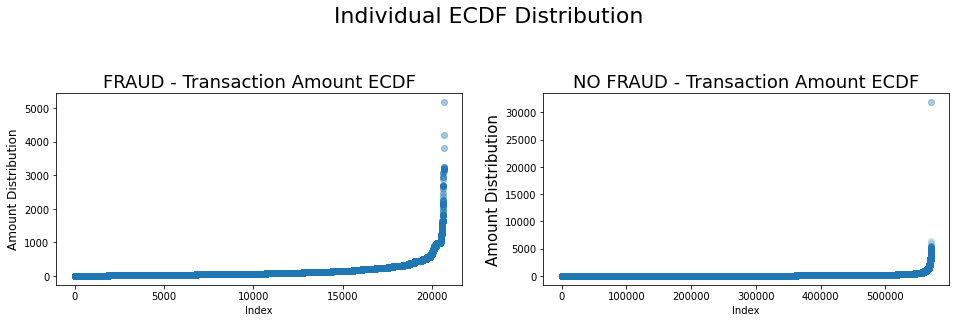

In [ ]:
plt.figure(figsize=(16,12))
plt.suptitle('Transaction Values Distribution', fontsize=22)
plt.subplot(221)
g = sns.distplot(df_trans[df_trans['TransactionAmt'] <= 1000]['TransactionAmt'])
g.set_title("Transaction Amount Distribuition <= 1000", fontsize=18)
g.set_xlabel("")
g.set_ylabel("Probability", fontsize=15)

plt.subplot(222)
g1 = sns.distplot(np.log(df_trans['TransactionAmt']))
g1.set_title("Transaction Amount (Log) Distribuition", fontsize=18)
g1.set_xlabel("")
g1.set_ylabel("Probability", fontsize=15)

plt.figure(figsize=(16,12))


plt.subplot(212)
g4 = plt.scatter(range(df_trans[df_trans['isFraud'] == 0].shape[0]),
                 np.sort(df_trans[df_trans['isFraud'] == 0]['TransactionAmt'].values), 
                 label='NoFraud', alpha=.2)
g4 = plt.scatter(range(df_trans[df_trans['isFraud'] == 1].shape[0]),
                 np.sort(df_trans[df_trans['isFraud'] == 1]['TransactionAmt'].values), 
                 label='Fraud', alpha=.2)
g4= plt.title("ECDF \nFRAUD and NO FRAUD Transaction Amount Distribution", fontsize=18)
g4 = plt.xlabel("Index")
g4 = plt.ylabel("Amount Distribution", fontsize=15)
g4 = plt.legend()

plt.figure(figsize=(16,12))

plt.subplot(321)
g = plt.scatter(range(df_trans[df_trans['isFraud'] == 1].shape[0]), 
                 np.sort(df_trans[df_trans['isFraud'] == 1]['TransactionAmt'].values), 
                label='isFraud', alpha=.4)
plt.title("FRAUD - Transaction Amount ECDF", fontsize=18)
plt.xlabel("Index")
plt.ylabel("Amount Distribution", fontsize=12)

plt.subplot(322)
g1 = plt.scatter(range(df_trans[df_trans['isFraud'] == 0].shape[0]),
                 np.sort(df_trans[df_trans['isFraud'] == 0]['TransactionAmt'].values), 
                 label='NoFraud', alpha=.2)
g1= plt.title("NO FRAUD - Transaction Amount ECDF", fontsize=18)
g1 = plt.xlabel("Index")
g1 = plt.ylabel("Amount Distribution", fontsize=15)

plt.suptitle('Individual ECDF Distribution', fontsize=22)

plt.show()


In [ ]:
print(pd.concat([df_trans[df_trans['isFraud'] == 1]['TransactionAmt']\
                 .quantile([.01, .1, .25, .5, .75, .9, .99])\
                 .reset_index(), 
                 df_trans[df_trans['isFraud'] == 0]['TransactionAmt']\
                 .quantile([.01, .1, .25, .5, .75, .9, .99])\
                 .reset_index()],
                axis=1, keys=['Fraud', "No Fraud"]))

  Fraud                No Fraud               
  index TransactionAmt    index TransactionAmt
0  0.01       6.739453     0.01       9.511875
1  0.10      18.937500     0.10      26.312500
2  0.25      35.031250     0.25      43.968750
3  0.50      75.000000     0.50      68.500000
4  0.75     161.000000     0.75     120.000000
5  0.90     335.000000     0.90     267.100000
6  0.99     994.000000     0.99    1104.000000


In [ ]:
CalcOutliers(df_trans['TransactionAmt'])

Identified lowest outliers: 0
Identified upper outliers: 10097
Total outlier observations: 10097
Non-outlier observations: 580443
Total percentual of Outliers:  1.7395


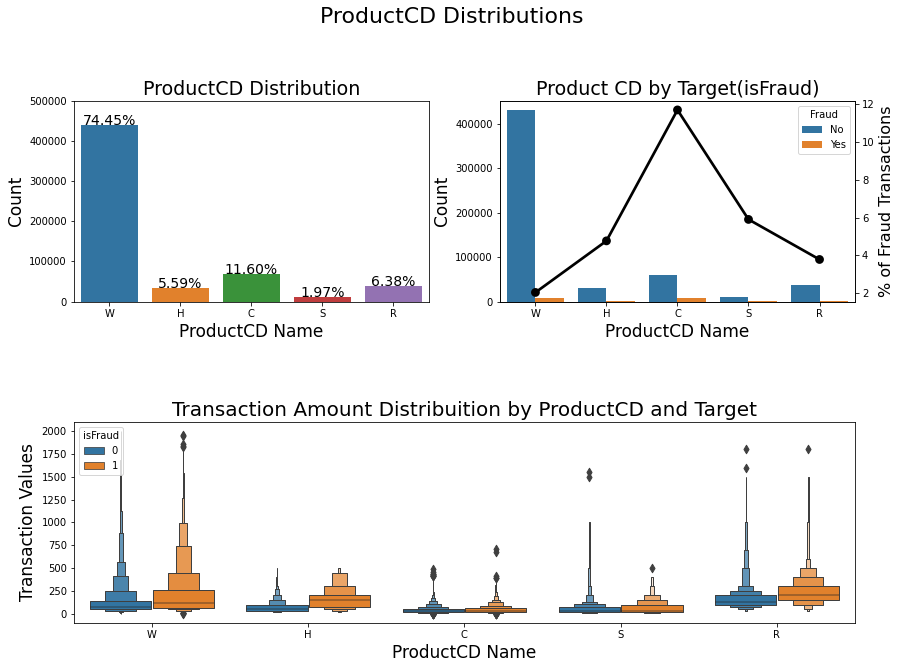

In [ ]:
tmp = pd.crosstab(df_trans['ProductCD'], df_trans['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,10))
plt.suptitle('ProductCD Distributions', fontsize=22)

plt.subplot(221)
g = sns.countplot(x='ProductCD', data=df_trans)
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])

g.set_title("ProductCD Distribution", fontsize=19)
g.set_xlabel("ProductCD Name", fontsize=17)
g.set_ylabel("Count", fontsize=17)
g.set_ylim(0,500000)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 

plt.subplot(222)
g1 = sns.countplot(x='ProductCD', hue='isFraud', data=df_trans)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
gt = g1.twinx()
gt = sns.pointplot(x='ProductCD', y='Fraud', data=tmp, color='black', order=['W', 'H',"C", "S", "R"], legend=False)
gt.set_ylabel("% of Fraud Transactions", fontsize=16)

g1.set_title("Product CD by Target(isFraud)", fontsize=19)
g1.set_xlabel("ProductCD Name", fontsize=17)
g1.set_ylabel("Count", fontsize=17)

plt.subplot(212)
g3 = sns.boxenplot(x='ProductCD', y='TransactionAmt', hue='isFraud', 
              data=df_trans[df_trans['TransactionAmt'] <= 2000] )
g3.set_title("Transaction Amount Distribuition by ProductCD and Target", fontsize=20)
g3.set_xlabel("ProductCD Name", fontsize=17)
g3.set_ylabel("Transaction Values", fontsize=17)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

In [ ]:
resumetable(df_trans[['card1', 'card2', 'card3','card4', 'card5', 'card6']])

Dataset Shape: (590540, 6)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,card1,int16,0,13553,13926,2755,4663,9.97
1,card2,float16,8933,500,NaN,404,490,6.32
2,card3,float16,1565,114,150,150,150,0.68
3,card4,object,1577,4,discover,mastercard,visa,1.09
4,card5,float16,4259,119,142,102,166,2.66
5,card6,object,1571,4,credit,credit,debit,0.82


In [ ]:
df_trans.loc[df_trans.card3.isin(df_trans.card3.value_counts()[df_trans.card3.value_counts() < 200].index), 'card3'] = "Others"
df_trans.loc[df_trans.card5.isin(df_trans.card5.value_counts()[df_trans.card5.value_counts() < 300].index), 'card5'] = "Others"

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

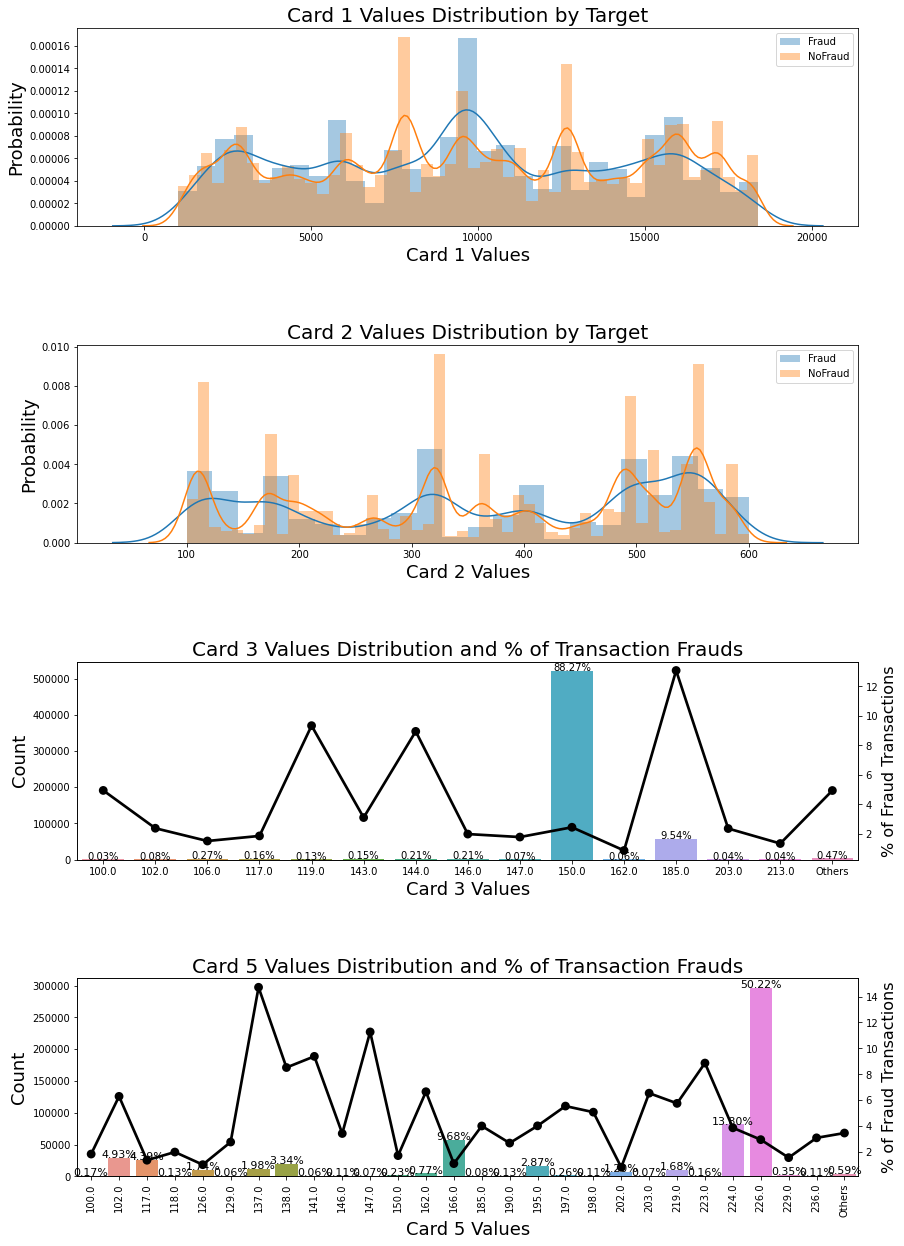

In [ ]:
tmp = pd.crosstab(df_trans['card3'], df_trans['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

tmp2 = pd.crosstab(df_trans['card5'], df_trans['isFraud'], normalize='index') * 100
tmp2 = tmp2.reset_index()
tmp2.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,22))

plt.subplot(411)
g = sns.distplot(df_trans[df_trans['isFraud'] == 1]['card1'], label='Fraud')
g = sns.distplot(df_trans[df_trans['isFraud'] == 0]['card1'], label='NoFraud')
g.legend()
g.set_title("Card 1 Values Distribution by Target", fontsize=20)
g.set_xlabel("Card 1 Values", fontsize=18)
g.set_ylabel("Probability", fontsize=18)

plt.subplot(412)
g1 = sns.distplot(df_trans[df_trans['isFraud'] == 1]['card2'].dropna(), label='Fraud')
g1 = sns.distplot(df_trans[df_trans['isFraud'] == 0]['card2'].dropna(), label='NoFraud')
g1.legend()
g1.set_title("Card 2 Values Distribution by Target", fontsize=20)
g1.set_xlabel("Card 2 Values", fontsize=18)
g1.set_ylabel("Probability", fontsize=18)

plt.subplot(413)
g2 = sns.countplot(x='card3', data=df_trans, order=list(tmp.card3.values))
g22 = g2.twinx()
gg2 = sns.pointplot(x='card3', y='Fraud', data=tmp, 
                    color='black', order=list(tmp.card3.values))
gg2.set_ylabel("% of Fraud Transactions", fontsize=16)
g2.set_title("Card 3 Values Distribution and % of Transaction Frauds", fontsize=20)
g2.set_xlabel("Card 3 Values", fontsize=18)
g2.set_ylabel("Count", fontsize=18)
for p in g2.patches:
    height = p.get_height()
    g2.text(p.get_x()+p.get_width()/2.,
            height + 25,
            '{:1.2f}%'.format(height/total*100),
            ha="center") 

plt.subplot(414)
g3 = sns.countplot(x='card5', data=df_trans, order=list(tmp2.card5.values))
g3t = g3.twinx()
g3t = sns.pointplot(x='card5', y='Fraud', data=tmp2, 
                    color='black', order=list(tmp2.card5.values))
g3t.set_ylabel("% of Fraud Transactions", fontsize=16)
g3.set_title("Card 5 Values Distribution and % of Transaction Frauds", fontsize=20)
g3.set_xticklabels(g3.get_xticklabels(),rotation=90)
g3.set_xlabel("Card 5 Values", fontsize=18)
g3.set_ylabel("Count", fontsize=18)
for p in g3.patches:
    height = p.get_height()
    g3.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=11) 
    
plt.subplots_adjust(hspace = 0.6, top = 0.85)


plt.show()

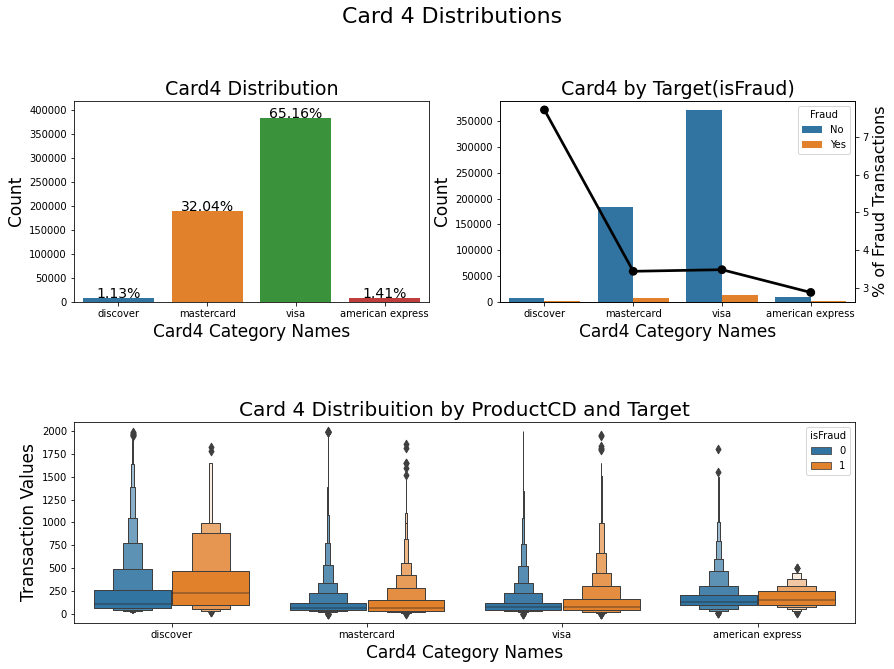

In [ ]:
tmp = pd.crosstab(df_trans['card4'], df_trans['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,10))
plt.suptitle('Card 4 Distributions', fontsize=22)

plt.subplot(221)
g = sns.countplot(x='card4', data=df_trans)
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])
g.set_title("Card4 Distribution", fontsize=19)
g.set_ylim(0,420000)
g.set_xlabel("Card4 Category Names", fontsize=17)
g.set_ylabel("Count", fontsize=17)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=14) 


plt.subplot(222)
g1 = sns.countplot(x='card4', hue='isFraud', data=df_trans)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
gt = g1.twinx()
gt = sns.pointplot(x='card4', y='Fraud', data=tmp, 
                   color='black', legend=False, 
                   order=['discover', 'mastercard', 'visa', 'american express'])
gt.set_ylabel("% of Fraud Transactions", fontsize=16)
g1.set_title("Card4 by Target(isFraud)", fontsize=19)
g1.set_xlabel("Card4 Category Names", fontsize=17)
g1.set_ylabel("Count", fontsize=17)

plt.subplot(212)
g3 = sns.boxenplot(x='card4', y='TransactionAmt', hue='isFraud', 
              data=df_trans[df_trans['TransactionAmt'] <= 2000] )
g3.set_title("Card 4 Distribuition by ProductCD and Target", fontsize=20)
g3.set_xlabel("Card4 Category Names", fontsize=17)
g3.set_ylabel("Transaction Values", fontsize=17)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

In [ ]:
for col in ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']:
    df_trans[col] = df_trans[col].fillna("Miss")
    
def ploting_dist_ratio(df, col, lim=2000):
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

    plt.figure(figsize=(20,5))
    plt.suptitle(f'{col} Distributions ', fontsize=22)

    plt.subplot(121)
    g = sns.countplot(x=col, data=df, order=list(tmp[col].values))
    # plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])
    g.set_title(f"{col} Distribution\nCound and %Fraud by each category", fontsize=18)
    g.set_ylim(0,400000)
    gt = g.twinx()
    gt = sns.pointplot(x=col, y='Fraud', data=tmp, order=list(tmp[col].values),
                       color='black', legend=False, )
    gt.set_ylim(0,20)
    gt.set_ylabel("% of Fraud Transactions", fontsize=16)
    g.set_xlabel(f"{col} Category Names", fontsize=16)
    g.set_ylabel("Count", fontsize=17)
    for p in gt.patches:
        height = p.get_height()
        gt.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center",fontsize=14) 
        
    perc_amt = (df_trans.groupby(['isFraud',col])['TransactionAmt'].sum() / total_amt * 100).unstack('isFraud')
    perc_amt = perc_amt.reset_index()
    perc_amt.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

    plt.subplot(122)
    g1 = sns.boxplot(x=col, y='TransactionAmt', hue='isFraud', 
                     data=df[df['TransactionAmt'] <= lim], order=list(tmp[col].values))
    g1t = g1.twinx()
    g1t = sns.pointplot(x=col, y='Fraud', data=perc_amt, order=list(tmp[col].values),
                       color='black', legend=False, )
    g1t.set_ylim(0,5)
    g1t.set_ylabel("%Fraud Total Amount", fontsize=16)
    g1.set_title(f"{col} by Transactions dist", fontsize=18)
    g1.set_xlabel(f"{col} Category Names", fontsize=16)
    g1.set_ylabel("Transaction Amount(U$)", fontsize=16)
        
    plt.subplots_adjust(hspace=.4, wspace = 0.35, top = 0.80)
    
    plt.show()

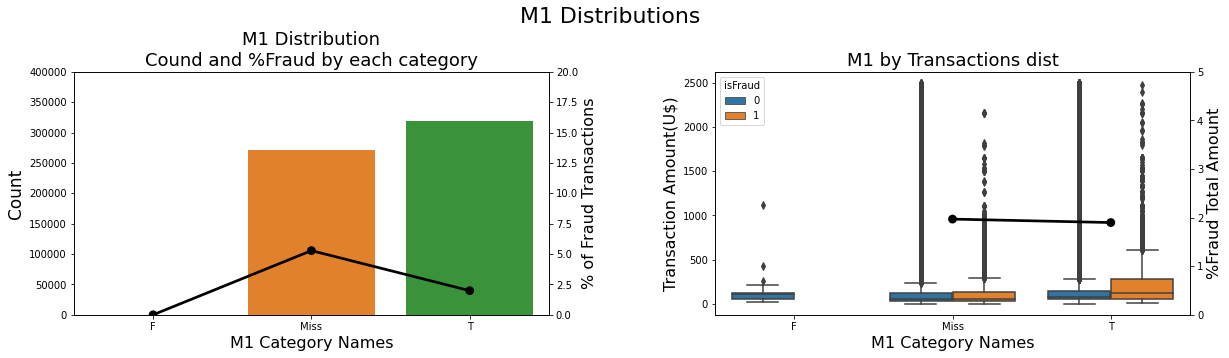

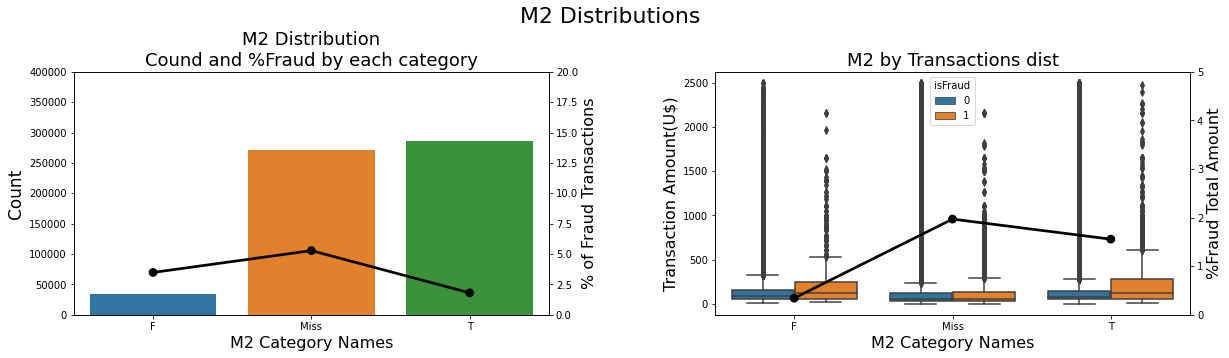

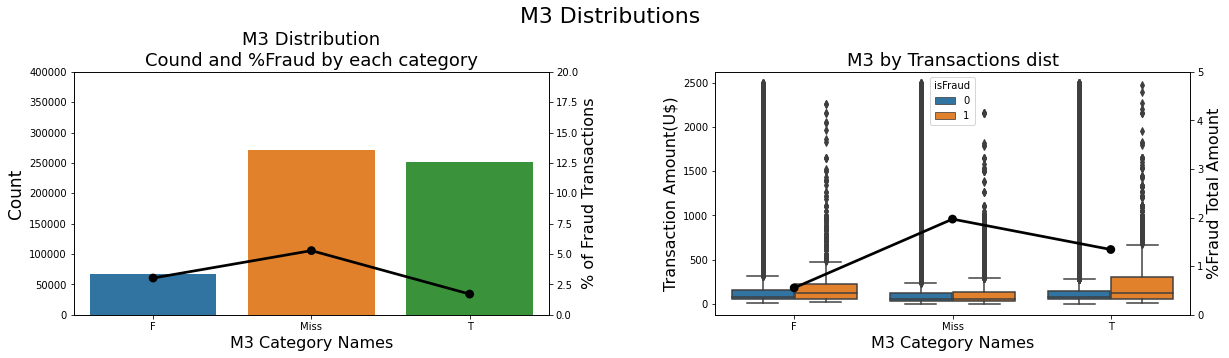

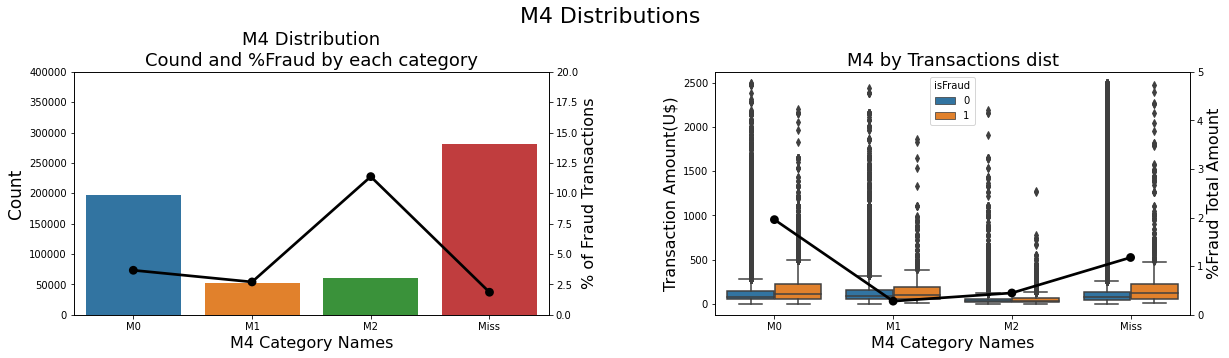

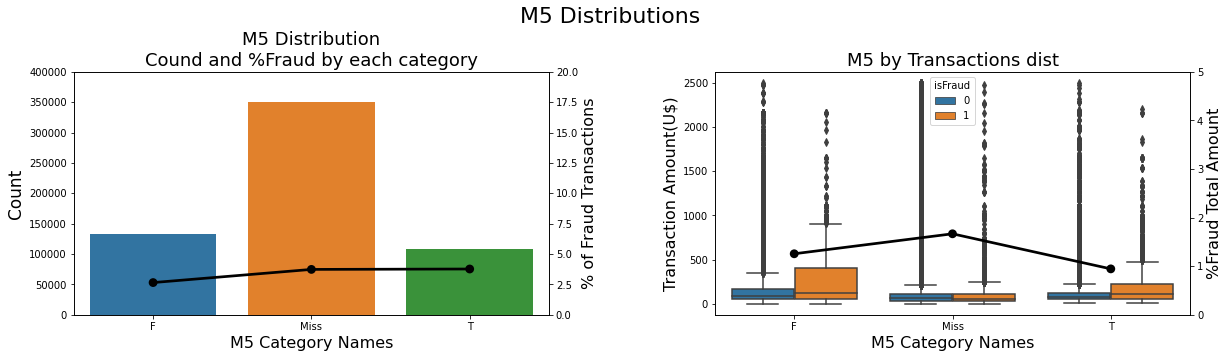

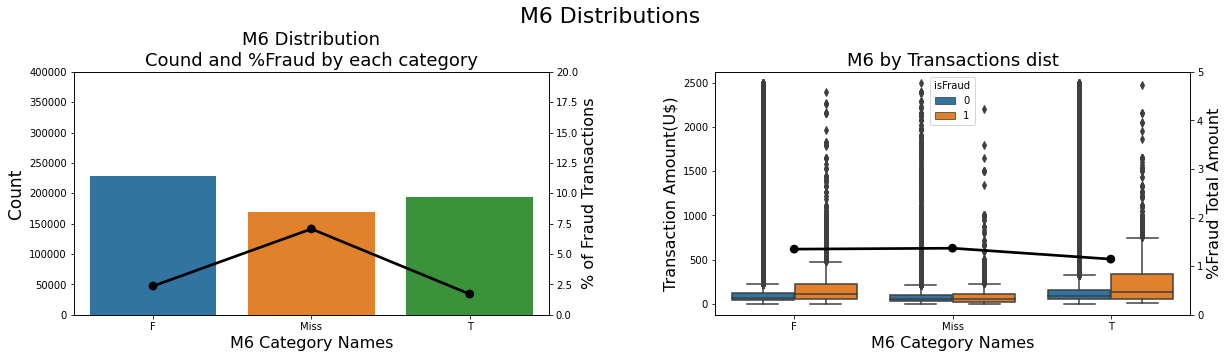

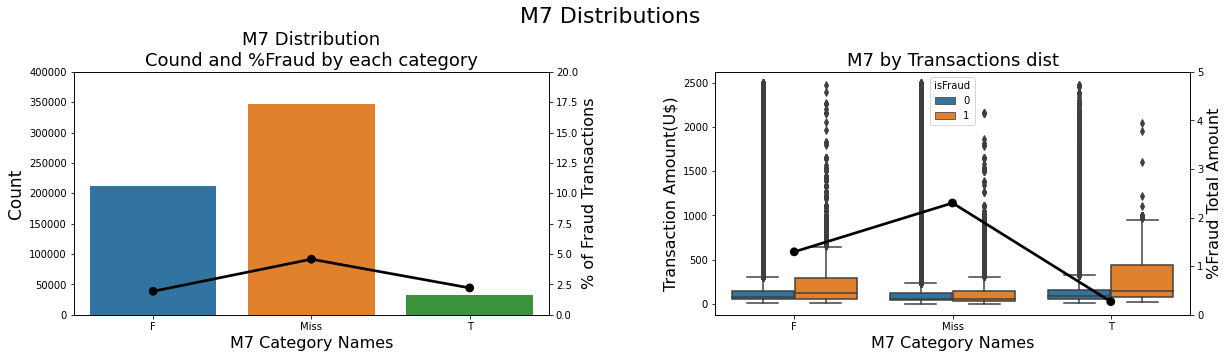

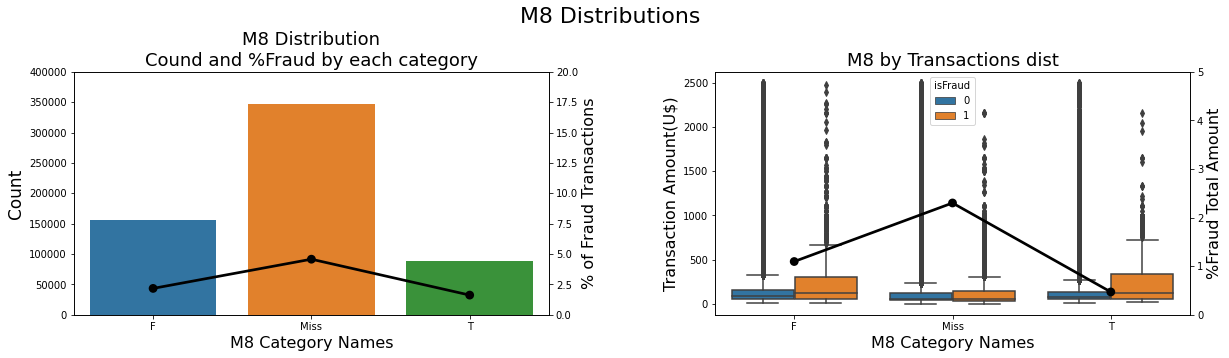

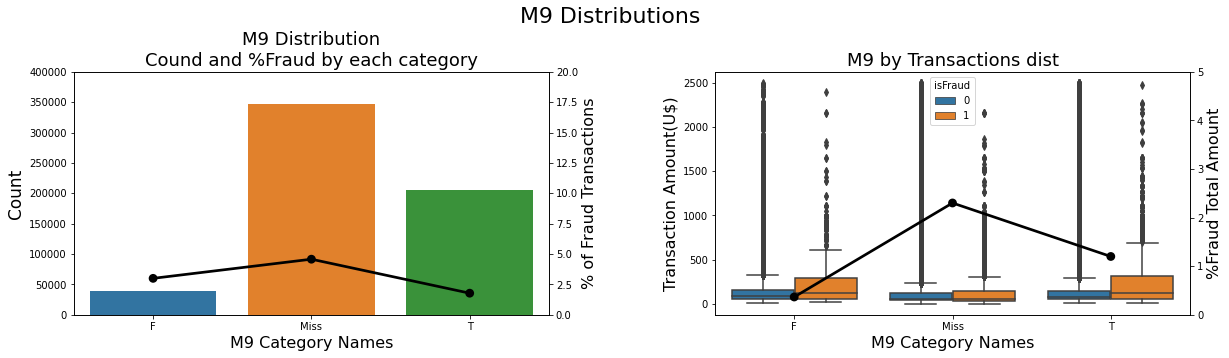

In [ ]:
for col in ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']:
    ploting_dist_ratio(df_trans, col, lim=2500)

In [ ]:
print("Card Features Quantiles: ")
print(df_trans[['addr1', 'addr2']].quantile([0.01, .025, .1, .25, .5, .75, .90,.975, .99]))

Card Features Quantiles: 
       addr1  addr2
0.010  123.0   87.0
0.025  123.0   87.0
0.100  177.0   87.0
0.250  204.0   87.0
0.500  299.0   87.0
0.750  330.0   87.0
0.900  441.0   87.0
0.975  498.0   87.0
0.990  512.0   87.0


In [ ]:
df_trans.loc[df_trans.addr1.isin(df_trans.addr1.value_counts()[df_trans.addr1.value_counts() <= 5000 ].index), 'addr1'] = "Others"
df_trans.loc[df_trans.addr2.isin(df_trans.addr2.value_counts()[df_trans.addr2.value_counts() <= 50 ].index), 'addr2'] = "Others"

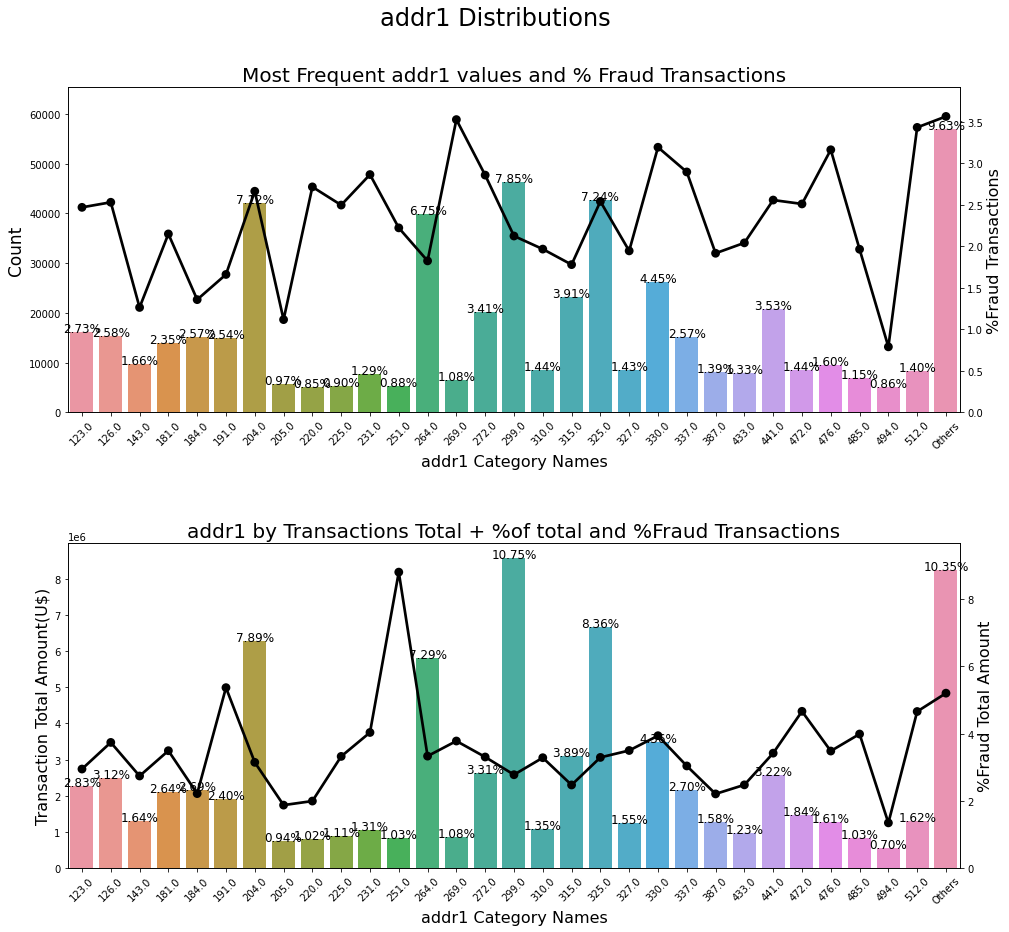

In [ ]:
 def ploting_cnt_amt(df, col, lim=2000):
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    
    plt.figure(figsize=(16,14))    
    plt.suptitle(f'{col} Distributions ', fontsize=24)
    
    plt.subplot(211)
    g = sns.countplot( x=col,  data=df, order=list(tmp[col].values))
    gt = g.twinx()
    gt = sns.pointplot(x=col, y='Fraud', data=tmp, order=list(tmp[col].values),
                       color='black', legend=False, )
    gt.set_ylim(0,tmp['Fraud'].max()*1.1)
    gt.set_ylabel("%Fraud Transactions", fontsize=16)
    g.set_title(f"Most Frequent {col} values and % Fraud Transactions", fontsize=20)
    g.set_xlabel(f"{col} Category Names", fontsize=16)
    g.set_ylabel("Count", fontsize=17)
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    sizes = []
    for p in g.patches:
        height = p.get_height()
        sizes.append(height)
        g.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center",fontsize=12) 
        
    g.set_ylim(0,max(sizes)*1.15)
    
    #########################################################################
    perc_amt = (df.groupby(['isFraud',col])['TransactionAmt'].sum() \
                / df.groupby([col])['TransactionAmt'].sum() * 100).unstack('isFraud')
    perc_amt = perc_amt.reset_index()
    perc_amt.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    amt = df.groupby([col])['TransactionAmt'].sum().reset_index()
    perc_amt = perc_amt.fillna(0)
    plt.subplot(212)
    g1 = sns.barplot(x=col, y='TransactionAmt', 
                       data=amt, 
                       order=list(tmp[col].values))
    g1t = g1.twinx()
    g1t = sns.pointplot(x=col, y='Fraud', data=perc_amt, 
                        order=list(tmp[col].values),
                       color='black', legend=False, )
    g1t.set_ylim(0,perc_amt['Fraud'].max()*1.1)
    g1t.set_ylabel("%Fraud Total Amount", fontsize=16)
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    g1.set_title(f"{col} by Transactions Total + %of total and %Fraud Transactions", fontsize=20)
    g1.set_xlabel(f"{col} Category Names", fontsize=16)
    g1.set_ylabel("Transaction Total Amount(U$)", fontsize=16)
    g1.set_xticklabels(g.get_xticklabels(),rotation=45)    
    
    for p in g1.patches:
        height = p.get_height()
        g1.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total_amt*100),
                ha="center",fontsize=12) 
        
    plt.subplots_adjust(hspace=.4, top = 0.9)
    plt.show()
    
ploting_cnt_amt(df_trans, 'addr1')

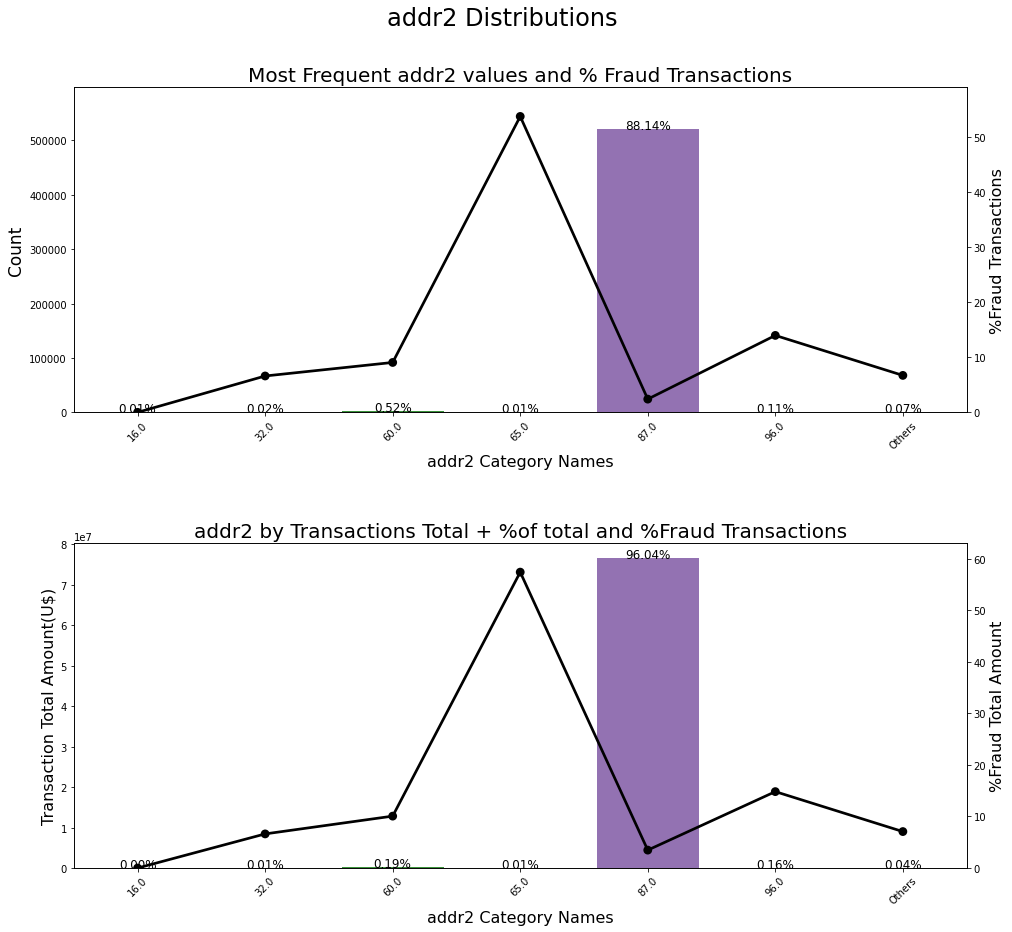

In [ ]:
ploting_cnt_amt(df_trans, 'addr2')

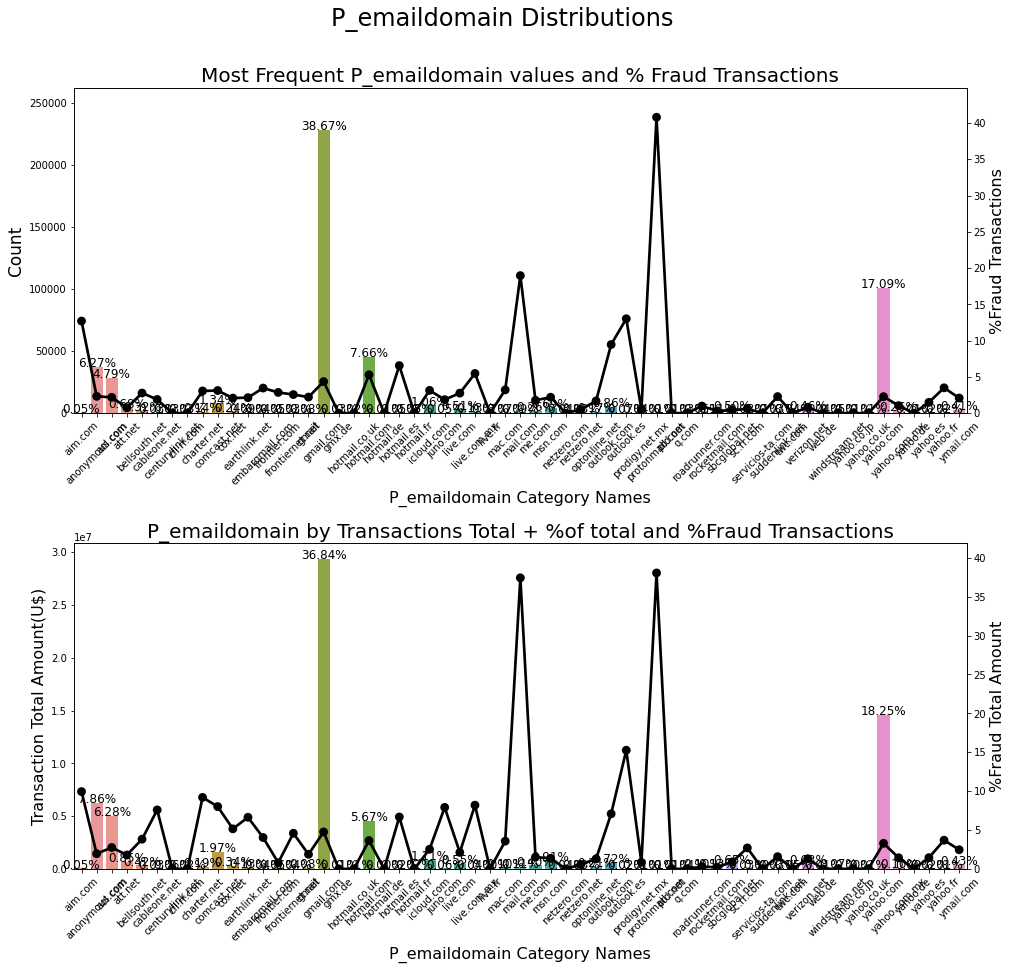

In [ ]:
ploting_cnt_amt(df_trans, 'P_emaildomain')

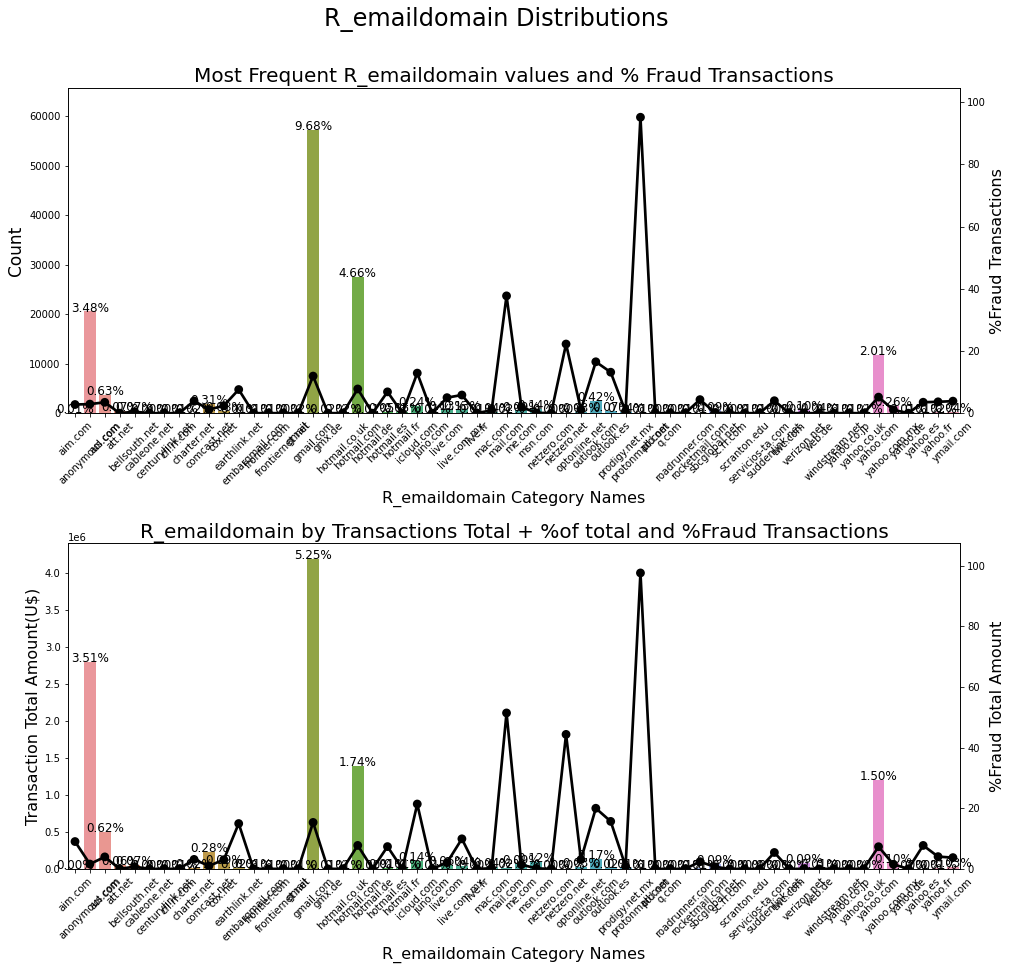

In [ ]:
ploting_cnt_amt(df_trans, 'R_emaildomain')

In [ ]:

resumetable(df_trans[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8',
                      'C9', 'C10', 'C11', 'C12', 'C13', 'C14']])

Dataset Shape: (590540, 14)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,C1,float16,0,1495,1.0,1.0,1.0,2.72
1,C2,float16,0,1167,1.0,1.0,1.0,2.75
2,C3,float16,0,27,0.0,0.0,0.0,0.04
3,C4,float16,0,1223,0.0,0.0,0.0,1.12
4,C5,float16,0,319,0.0,0.0,0.0,2.06
5,C6,float16,0,1291,1.0,1.0,1.0,2.52
6,C7,float16,0,1069,0.0,0.0,0.0,0.71
7,C8,float16,0,1130,0.0,0.0,0.0,1.25
8,C9,float16,0,205,1.0,0.0,1.0,2.62
9,C10,float16,0,1122,0.0,0.0,0.0,1.23


In [ ]:
df_trans[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8',
                      'C9', 'C10', 'C11', 'C12', 'C13', 'C14']].describe()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
count,590540.0,590540.0,590540.000000,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0
mean,NaN,NaN,0.005650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,0.150635,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
min,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,1.0,1.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
50%,1.0,1.0,0.000000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,1.0
75%,3.0,3.0,0.000000,0.0,1.0,2.0,0.0,0.0,2.0,0.0,2.0,0.0,12.0,2.0
max,4684.0,5692.0,26.000000,2252.0,349.0,2252.0,2256.0,3332.0,210.0,3256.0,3188.0,3188.0,2918.0,1429.0


In [ ]:
df_trans.loc[df_trans.C1.isin(df_trans.C1\
                              .value_counts()[df_trans.C1.value_counts() <= 400 ]\
                              .index), 'C1'] = "Others"

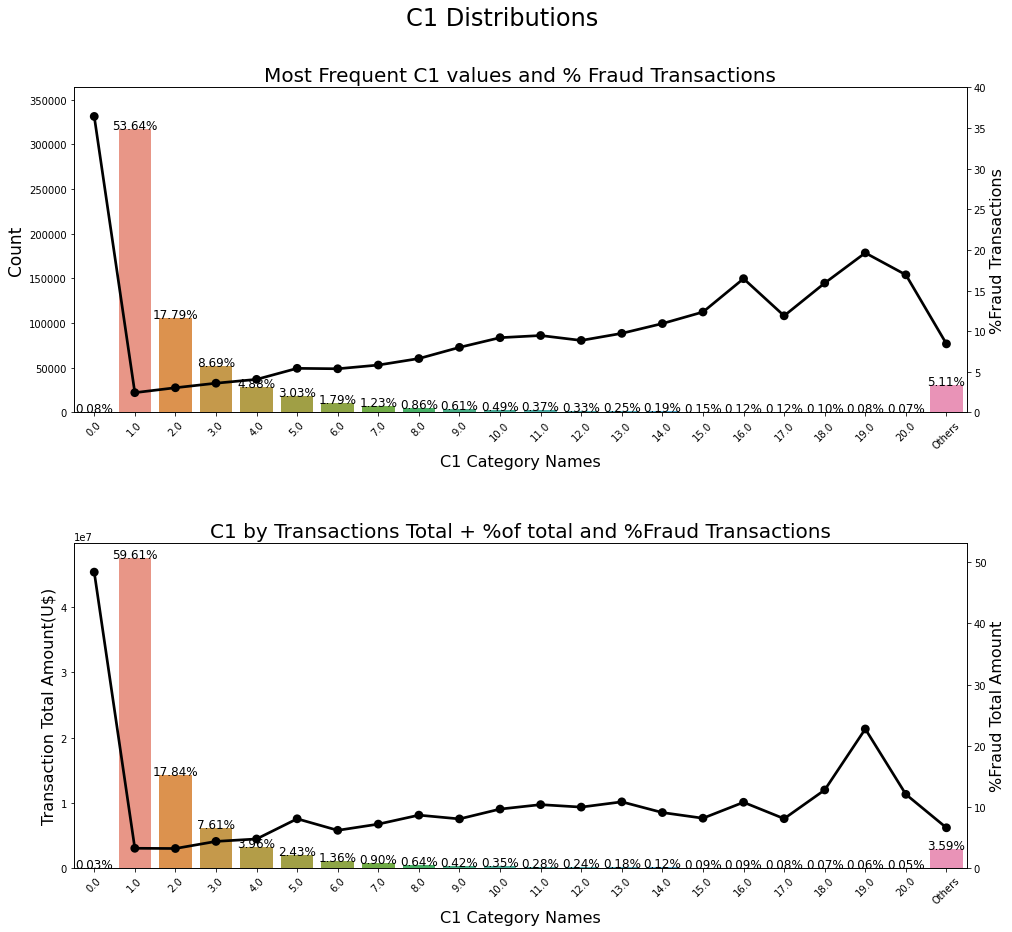

In [ ]:
ploting_cnt_amt(df_trans, 'C1')

In [ ]:
df_trans.loc[df_trans.C2.isin(df_trans.C2\
                              .value_counts()[df_trans.C2.value_counts() <= 350 ]\
                              .index), 'C2'] = "Others"

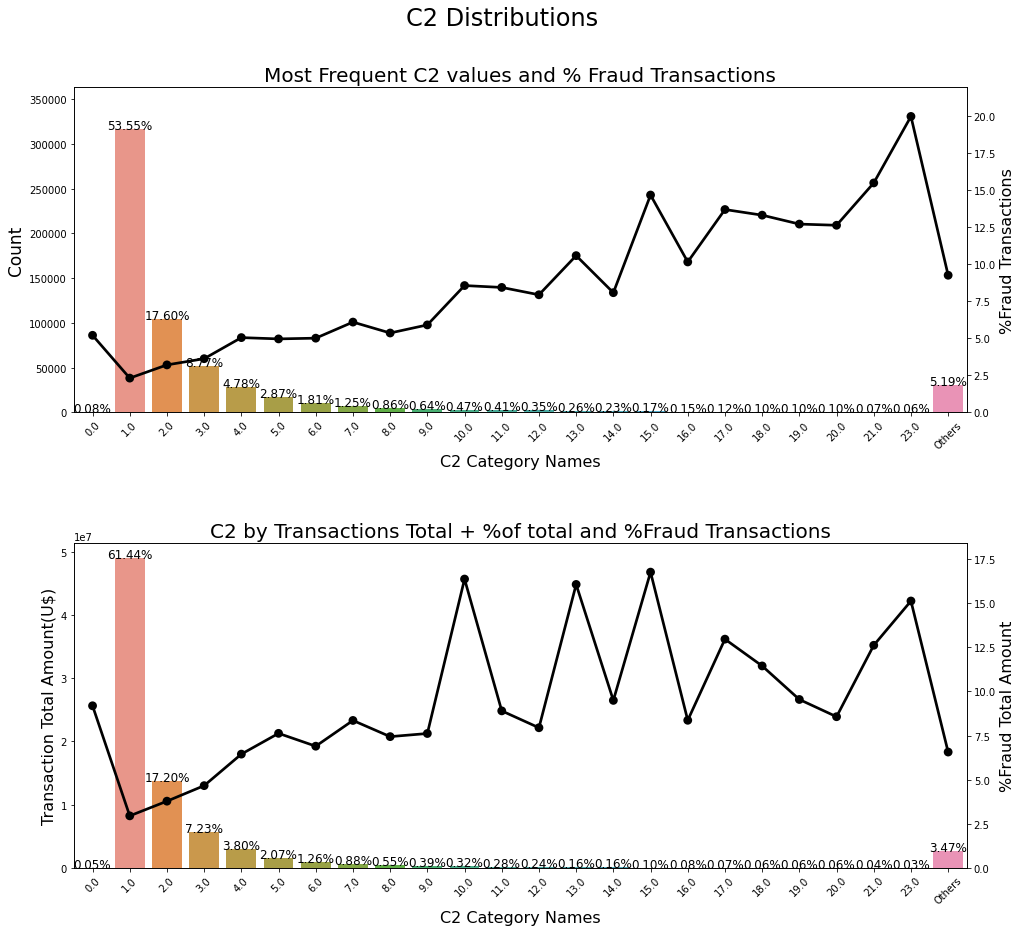

In [ ]:
ploting_cnt_amt(df_trans, 'C2')

In [ ]:
import datetime

START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
df_trans["Date"] = df_trans['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))

df_trans['_Weekdays'] = df_trans['Date'].dt.dayofweek
df_trans['_Hours'] = df_trans['Date'].dt.hour
df_trans['_Days'] = df_trans['Date'].dt.day

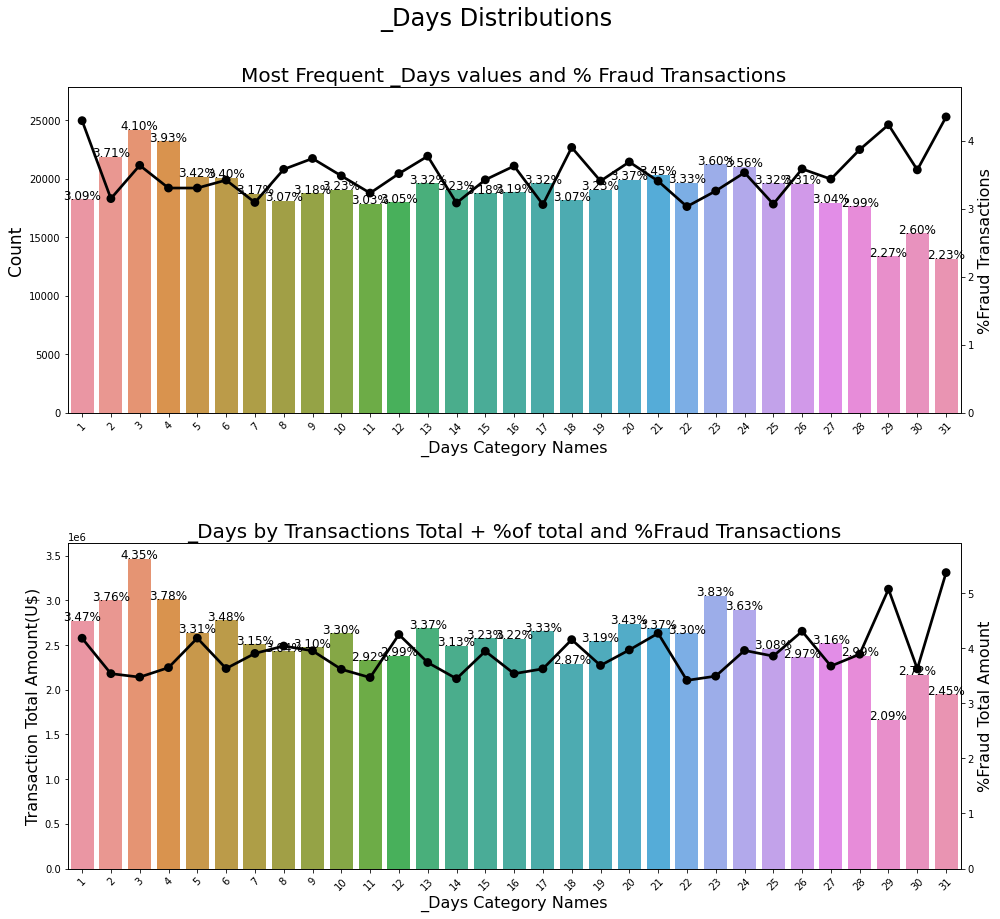

In [ ]:
ploting_cnt_amt(df_trans, '_Days')

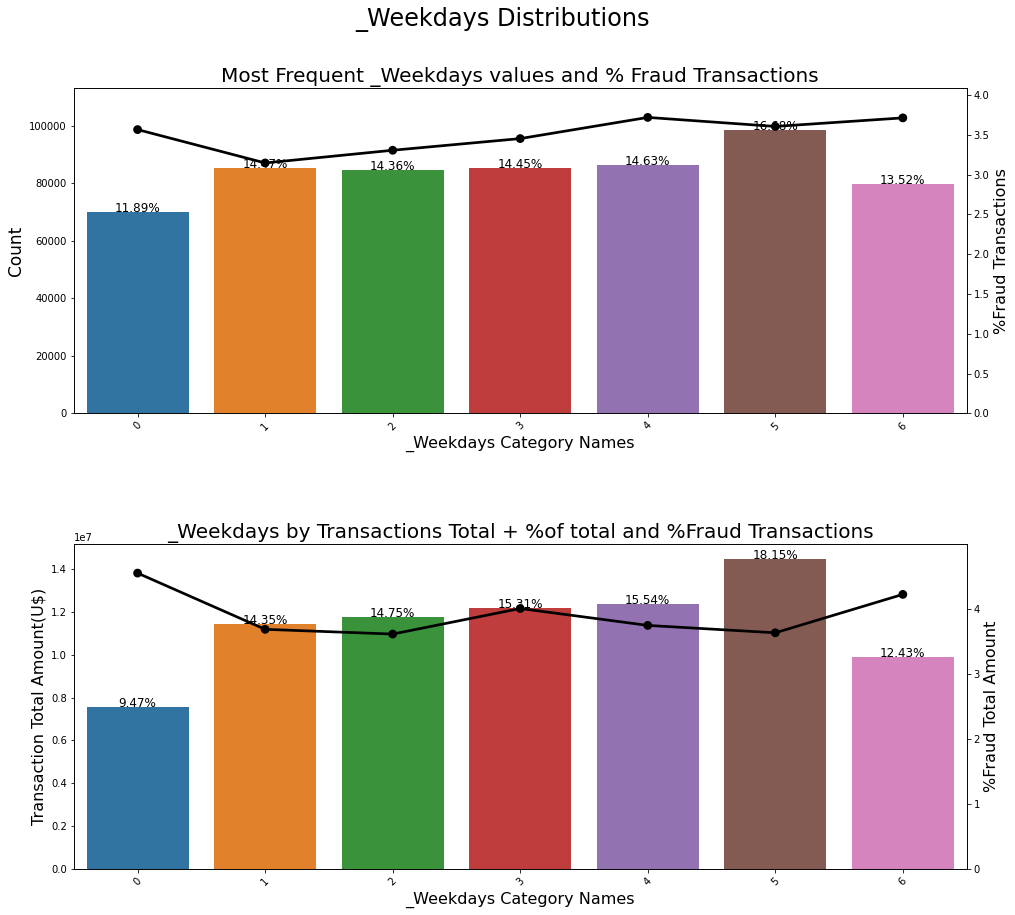

In [ ]:
ploting_cnt_amt(df_trans, '_Weekdays')

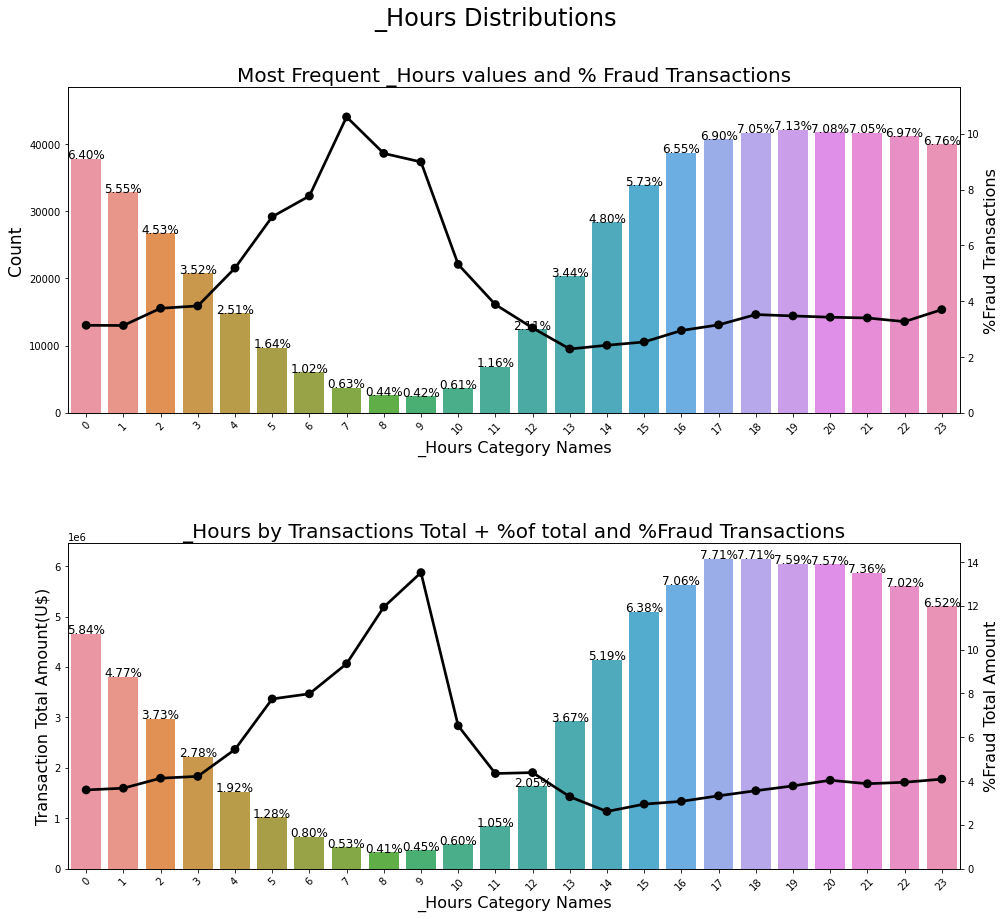

In [ ]:
ploting_cnt_amt(df_trans, '_Hours')

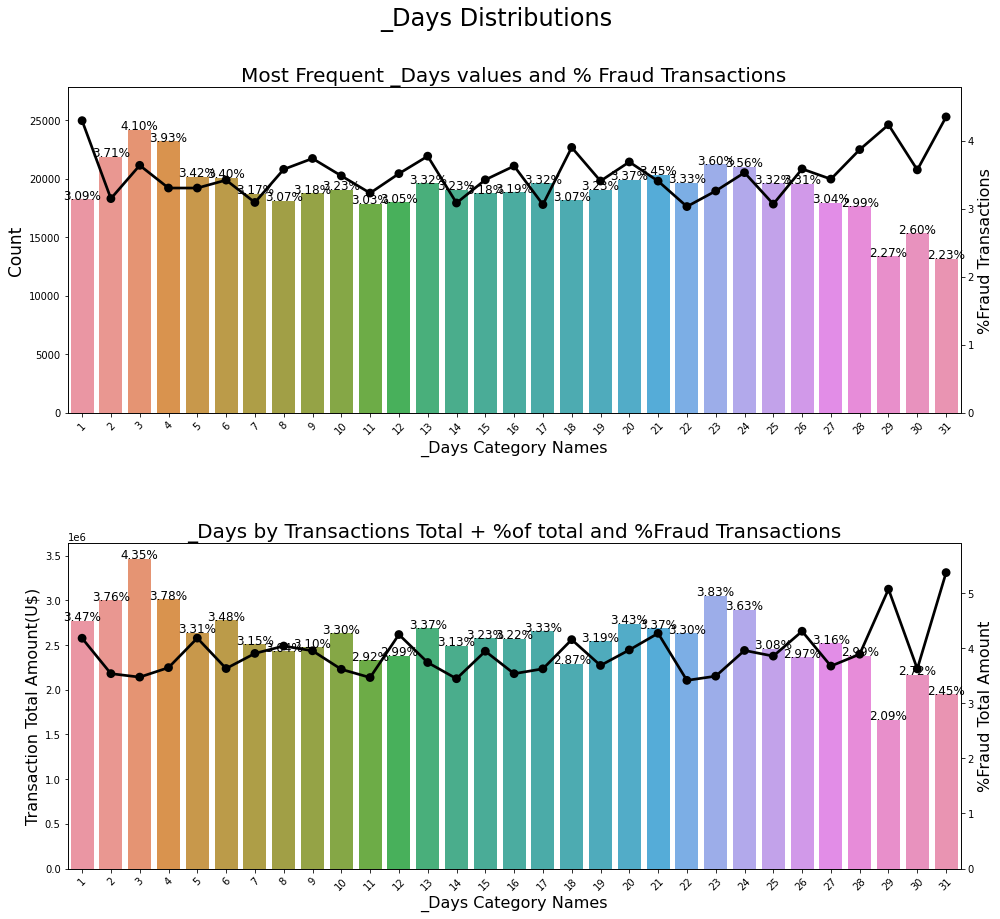

In [ ]:
ploting_cnt_amt(df_trans, '_Days')


In [ ]:
#seting some static color options
color_op = ['#5527A0', '#BB93D7', '#834CF7', '#6C941E', '#93EAEA', '#7425FF', '#F2098A', '#7E87AC', 
            '#EBE36F', '#7FD394', '#49C35D', '#3058EE', '#44FDCF', '#A38F85', '#C4CEE0', '#B63A05', 
            '#4856BF', '#F0DB1B', '#9FDBD9', '#B123AC']

tmp_amt = df_trans.groupby([df_trans.Date.dt.date, 'isFraud'])['TransactionAmt'].sum().reset_index()
tmp_trans = df_trans.groupby([df_trans.Date.dt.date, 'isFraud'])['TransactionAmt'].count().reset_index()

tmp_trans_fraud = tmp_trans[tmp_trans['isFraud'] == 1]
tmp_amt_fraud = tmp_amt[tmp_amt['isFraud'] == 1]

dates_temp = df_trans.groupby(df_trans.Date.dt.date)['TransactionAmt'].count().reset_index()
# renaming the columns to apropriate names

# creating the first trace with the necessary parameters
trace = go.Scatter(x=tmp_trans_fraud['Date'], y=tmp_trans_fraud.TransactionAmt,
                    opacity = 0.8, line = dict(color = color_op[1]), name= 'Fraud Transactions')

# using the new dates_temp_sum we will create the second trace
trace1 = go.Scatter(x=tmp_amt_fraud.Date, line = dict(color = color_op[7]), name="Fraud Amount",
                    y=tmp_amt_fraud['TransactionAmt'], opacity = 0.8, yaxis='y2')

#creating the layout the will allow us to give an title and 
# give us some interesting options to handle with the outputs of graphs
layout = dict(
    title= "FRAUD TRANSACTIONS - Total Transactions and Fraud Informations by Date",
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label='1m', step='month', stepmode='backward'),
                dict(count=3, label='3m', step='month', stepmode='backward'),
                dict(count=6, label='6m', step='month', stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(visible = True),
        type='date' ),
    yaxis=dict(title='Total Transactions'),
    yaxis2=dict(overlaying='y',
                anchor='x', side='right',
                zeroline=False, showgrid=False,
                title='Total Transaction Amount')
)

# creating figure with the both traces and layout
fig = dict(data= [trace, trace1], layout=layout)

#rendering the graphs
plotly.offline.iplot(fig) #it's an equivalent to plt.show()
